In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('arxiv_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51774 entries, 0 to 51773
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     51774 non-null  object
 1   summaries  51774 non-null  object
 2   terms      51774 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [4]:
df.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [5]:
df = df.drop_duplicates(subset=['titles', 'summaries'])

In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38985 entries, 0 to 51772
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   titles     38985 non-null  object
 1   summaries  38985 non-null  object
 2   terms      38985 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


### Document Length Analysis
We analyze the distribution of summaries length to understand content variation.


In [8]:
# Sample 100 rows
df_sample = df.sample(n=1000, random_state=42)

count    1000.000000
mean      171.464000
std        46.254256
min        38.000000
25%       139.000000
50%       170.000000
75%       201.000000
max       307.000000
Name: summary_length, dtype: float64


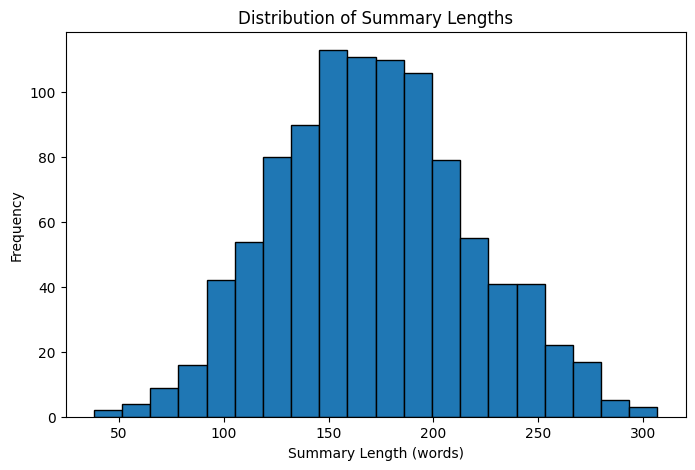

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Compute document lengths
df_sample["summary_length"] = df_sample["summaries"].apply(lambda x: len(x.split()))

# Display summary statistics
print(df_sample["summary_length"].describe())

# Plot histogram of document lengths
plt.figure(figsize=(8,5))
plt.hist(df_sample["summary_length"], bins=20, edgecolor='black')
plt.xlabel("Summary Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Summary Lengths")
plt.show()


In [10]:
# 3. Vocabulary Size Calculation
# To get an estimate of the dataset's vocabulary size:

from collections import Counter

# Join all text data and count unique words
all_words = " ".join(df_sample["summaries"]).split()
vocab_count = Counter(all_words)

print(f"Vocabulary size: {len(vocab_count)}")

Vocabulary size: 18325


               Topic  Count
0              cs.CV    571
4              cs.LG    565
5            stat.ML    302
7              cs.AI    148
12             cs.RO     39
..               ...    ...
71             65K10      1
72             G.1.6      1
74             97R40      1
75     I.2.11; I.2.6      1
112  physics.comp-ph      1

[113 rows x 2 columns]


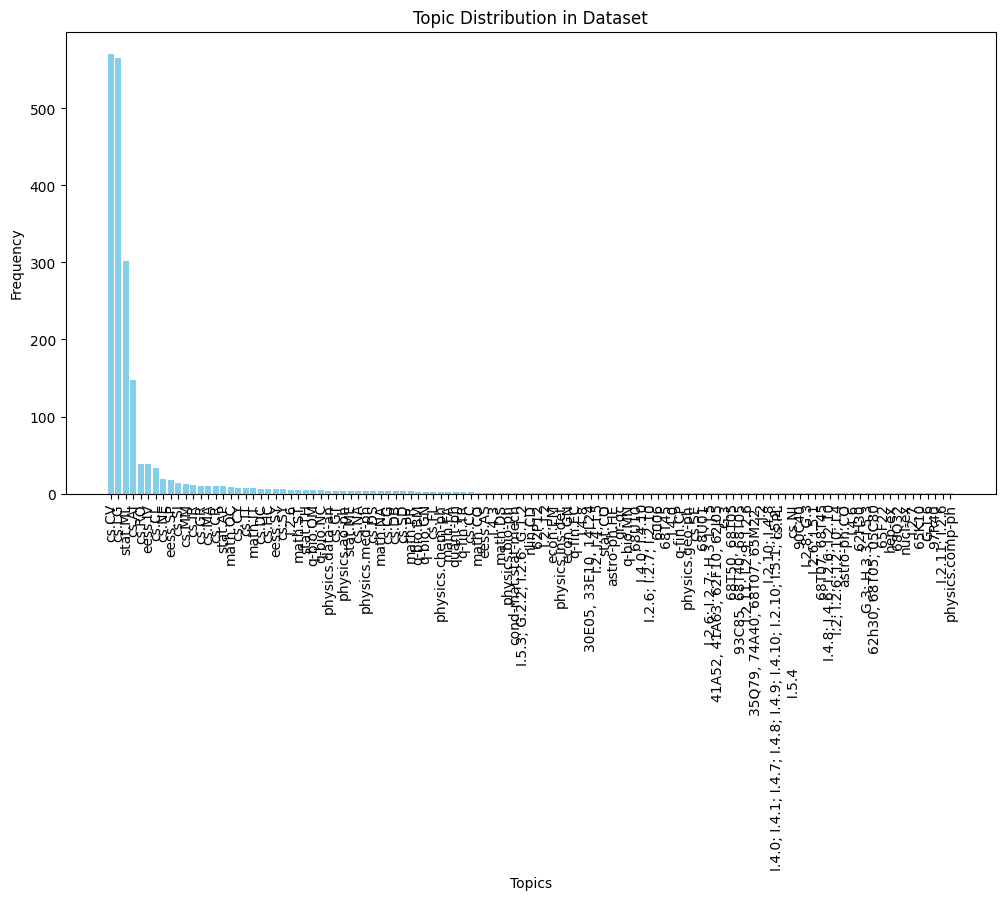

In [11]:
# # 4. Topic Distribution Analysis
# # The terms column contains multiple topic labels per document. We will flatten and count their occurrences.

# from collections import Counter
# import pandas as pd
# import matplotlib.pyplot as plt

# # Count occurrences of each unique title (topic)
# topic_counts = df["terms"].value_counts()

# # Convert to DataFrame for visualization
# topic_df = topic_counts.reset_index()
# topic_df.columns = ["Topic", "Count"]

# # Display topic frequency
# print(topic_df)

# # Plot topic distribution
# plt.figure(figsize=(10, 5))
# plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
# plt.xticks(rotation=90)  # Rotate for better readability if too many topics
# plt.xlabel("Topics")
# plt.ylabel("Frequency")
# plt.title("Topic Distribution in Dataset")
# plt.show()

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import ast  # To safely convert string lists into actual lists

# Flatten the topic lists
all_topics = []
for topics in df_sample["terms"]:
    topic_list = ast.literal_eval(topics)  # Convert string list to actual list
    all_topics.extend(topic_list)  # Add all topics to a single list

# Count occurrences of each unique topic
topic_counts = Counter(all_topics)

# Convert to DataFrame for visualization
topic_df = pd.DataFrame(topic_counts.items(), columns=["Topic", "Count"]).sort_values(by="Count", ascending=False)

# Display topic frequency
print(topic_df)

# Plot topic distribution
plt.figure(figsize=(12, 6))
plt.bar(topic_df["Topic"], topic_df["Count"], color='skyblue')
plt.xticks(rotation=90)  # Rotate for better readability if too many topics
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.title("Topic Distribution in Dataset")
plt.show()


## RAG Model with LLM Generated Dataset Questions
The following RAG Model was given the 15 original questions from our initial run, but also new questions generated from the LLM (including relevant and irrelevant topics to the documents)

In [42]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load models
embedding_model = SentenceTransformer('BAAI/bge-small-en')
generation_model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-small')
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-small')


# 2. Hardcoded Questions (replace dynamic generation)
hardcoded_questions = [
   "What issue does consistency training face?",
    "What is EHT used for?",
    "What challenge do deep models face?",
    "How does transfer learning reduce data labeling costs?",
    "What is StructBoost in boosting algorithms?",
    "What problem does Augmented CycleGAN address?",
    "What does the new algorithm for transductive inference optimize?",
    "What does DSAL combine for image segmentation?",
    "What problem does StructBoost address in multi-source domain adaptation?",
    "What is the benefit of using surrogate maximization for performance metrics?",
    "How does the point-set kernel measure compute similarity between objects?",
    "How does the 'Adversarial Payload Loss' evade malware detection while preserving functionality?",
    "How does AI-powered 3D image segmentation enable personalized treatment planning in oncology?",
    "What strategies can be used to enhance teamwork and communication in Agile environments?",
    "How can data-driven insights optimize customer support in retail environments?"
]

# 3. Evaluate RAG Model based on hardcoded questions
def evaluate_rag(df, questions, top_k=3):
    results = []

    for question in questions:
        # Embed the question
        query_embedding = embedding_model.encode(question, convert_to_tensor=True)

        # Embed all documents in the dataset
        doc_embeddings = embedding_model.encode(df['summaries'].tolist(), convert_to_tensor=True)

        # Retrieve top-k relevant documents based on similarity
        similarities = util.pytorch_cos_sim(query_embedding, doc_embeddings)[0]

        # Make a copy of the array to avoid negative stride errors
        similarities_copy = similarities.cpu().numpy().copy()

        top_indices = np.argsort(similarities_copy)[-top_k:][::-1]

        retrieved_docs = df.iloc[top_indices]

        # Generate an answer based on the retrieved documents
        doc_context = " ".join(retrieved_docs['summaries'].tolist())
        input_text = f"Answer the question: {question} Based on the following documents: {doc_context[:1500]}"

        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding="longest", max_length=1024)
        outputs = generation_model.generate(**inputs, max_length=150, num_return_sequences=1)
        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Store the results
        results.append({
            'question': question,
            'answer': answer,
            'retrieved_docs': retrieved_docs['summaries'].tolist(),
            'retrieved_titles': retrieved_docs['titles'].tolist(),
            'retrieved_terms': retrieved_docs['terms'].tolist(),
            'similarities': similarities_copy[top_indices].tolist()  # Using the copied similarities array
        })

    return pd.DataFrame(results)

In [43]:
# Get results from the RAG evaluation
results_df = evaluate_rag(df_sample, hardcoded_questions)

In [44]:
# Save Final Results
results_df.to_csv('short_rag_llm_evaluation_results.csv', index=False)
print("Evaluation completed and results saved to 'short_rag_llm_evaluation_results.csv'.")

Evaluation completed and results saved to 'short_rag_llm_evaluation_results.csv'.


# Evaluation of RAG Model Performance: LLM vs. Manual Assessment

## Question Generation:
    "What does deep reinforcement learning combine?", #['cs.CV']
    "What is the main focus of the research in this paper regarding Blockchain technologies?", #['cs.SI']
    "What does pose information represent in Capsule Networks?", #['cs.AI']
    "What are the key components of VA-GAN?", #['eess.IV']
    "How does the paper contribute to understanding the network dynamics behind cryptocurrencies like Bitcoin?", #['stat.ML']
    "What specific image processing algorithms were used to transform RNA sequences into gene motifs for the CNN classification?", #['cs.RO']
    "What is the role of camera-aware domain adaptation in the proposed method?", #['cs.AI']
    "What is the primary goal of the Structure Transfer Machine (STM) method?", #['cs.RO']
    "What is the role of the manifold structure in STM?", #['cs.CV']
    "Where can the source code for STM be accessed?", #['eess.IV']
    "What are the three main challenges in multi-task reinforcement learning?", #['cs.SI']
    "What is the main goal of self-supervised methods in reinforcement learning?", #['stat.ML']
    "How does the proposed Local and Global Diffusion (LGD) framework address this limitation?", #['cs.LG']
    "What is the role of diffusions in the LGD network?", #['q-fin.ST']
    "How many categories and images are included in the UDD dataset?", #['eess.IV']
    "What are the recent advancements in graph neural networks?", #['q-fin.ST']
    "How is contrastive learning used in computer vision applications?", #['q-fin.ST']
    "What role does self-supervised learning play in improving model performance?", #['cs.AI']
    "How does knowledge distillation contribute to deep learning efficiency?", #['cs.AI']
    "What are the key differences between traditional and quantum machine learning?", #['cs.CV']
    "What were the primary causes of the fall of the Roman Empire?", #['cs.LG']
    "How did Renaissance art influence modern painting techniques?", #['cs.AI']
    "What are the philosophical implications of time travel?", #['eess.IV']
    "How does astrology determine personality traits?", #['cs.LG']
    "What are the traditional methods of winemaking in France?", #['stat.ML']
    "What role did mythology play in ancient Greek society?", #['cs.SI']
    "What are the main techniques used in composing classical symphonies?", #['cs.AI']
    "How has urban planning evolved in the last century?", #['cs.CV']
    "What are the core principles of homeopathy?", #['q-fin.ST']
    "What impact does climate change have on deep-sea marine ecosystems?", #['stat.ML']
    "How do historians verify ancient manuscripts?", #['eess.IV']
    "What are the main psychological theories explaining human creativity?", #['cs.LG']

## 4o Model Performance (first round):
### 1. Underestimated Performance
- Some responses were marked as incorrect when they were actually **partially correct** or **almost correct**.
- If an answer is almost correct but contains minor errors, an ideal evaluator should consider this, which the LLM failed to do.

### 2. Failure to Identify Out-of-Scope Questions
- The LLM evaluated questions outside the dataset's domain instead of marking them as **unanswerable**.
- Example: Questions about the Roman Empire, Renaissance art, and astrology should not have been evaluated.
- These out-of-scope topics were also considered as not missing any documents - despite there being no documents about them in the dataset 

### 3. Inconsistent Runs
- When using a different prompt or trying to add extra information to the LLM to evaluate, it gave completely different results (see screenshot 3) - indicating no hallucinated records, when it initially said every one had hallucinated.
- Attempted to shorten the question set, but still recieved all incorrect responses from the LLM. (see screenshot 4)

## o1 Model Performance:
### 1. Unable to actually evaluate and compare
- It provided a good baseline for structure and an 'example' of what it should look like.
- Couldn't perform the actual evaluation and just used placeholder numbers (see screenshot 2).

## Attempted Calling the API in Code:
- Couldn't parse through properly without the ability to continually prompt the LLM.
- Returned errors for every single evaluation.


## Usefulness of the LLM in Evaluating RAG

### Strengths
- **Time Efficiency:** The LLM processed evaluations much faster than manual checking.
- **Quantitative Metrics:** Provided structured precision, recall, and F1-scores for multiple queries quickly and accuractely (to its own labelling).

### Weaknesses
- **Contextual Misinterpretation:** The LLM could not distinguish hallucinated answers from correct retrievals.
- **Failure to Detect Partial Correctness:** It struggled to differentiate between fully correct, almost correct, and incorrect answers.
- **Poor Handling of Out-of-Scope Questions:** Evaluated irrelevant queries instead of marking them as **unanswerable**.


## Conclusion
- The LLM provided a **useful** baseline for RAG evaluation but lacked nuance in its assessments.
- **Manual verification remains necessary** to:
  - Detect hallucinations and retrieval failures.
  - Identify **out-of-scope** questions.
  - Improve **evaluation accuracy** by distinguishing partial correctness.
- A **hybrid approach**—using LLM for initial assessments and manual checks for edge cases—would be the most effective strategy.


![LLM 4o](llm_4o_eval.png)

![LLM 4o](llm_o1_eval.png)

![LLM 4o](llm_4o_eval_2.png)

![LLM 4o](llm_4o_short_eval.png)

# Attempting to automate the LLM Evaluation Process

## Using OpenAi API Services
### 1. Referencing the API Key

In [15]:
import openai
import time
import json
from openai import OpenAI

In [16]:
client = openai.OpenAI(
  api_key=""
)

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[
    {"role": "user", "content": "write a haiku about ai"}
  ]
)

print(completion.choices[0].message);

ChatCompletionMessage(content='Silent circuits hum,  \nWisdom woven through the code,  \nDreams of metal minds.  ', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


In [17]:
df_arxiv = pd.read_csv("arxiv_data.csv")  # Original ground-truth dataset
df_rag = pd.read_csv("rag_llm_evaluation_results.csv")  # RAG-generated results

### 2. Giving prompt to the LLM and try catches to do: 

In [29]:
def evaluate_rag_with_llm(question, answer, retrieved_docs, original_data, max_retries=3):
    """
    Uses GPT-4 API to evaluate RAG-generated answers based on retrieved documents
    and original ground-truth data. Returns a CSV-friendly format.
    """
    prompt = f"""
    You are an expert evaluator assessing a Retrieval-Augmented Generation (RAG) model.
    
    **Ground Truth Data (Original Documents):**
    {original_data}

    **User Question:** {question}
    
    **Generated Answer:** {answer}
    
    **Retrieved Documents:** 
    {retrieved_docs}

    **Evaluation Instructions:** 
    - Label each retrieved document as **Correct** or **Incorrect**.
    - Identify any documents that **should have been retrieved** but were missing.
    - Check if the generated answer contains **hallucinated (false) information**.
    - Calculate **Precision, Recall, F1-score, and Accuracy** based on retrieved document correctness.

    **Return the output in a CSV-friendly table format with the following columns:**
    ```
    Question, Generated Answer, Retrieved Docs, Correct Docs, Incorrect Docs, Missing Docs, Hallucination (Yes/No), Precision, Recall, F1-score, Accuracy, Evaluation Comment
    "What is AI?", "AI is a machine learning field.", "Doc1, Doc2", "Doc1", "Doc2", "Doc3", "No", 0.75, 0.80, 0.77, 0.78, "The answer is mostly correct."
    ```
    **Do not include any extra text, explanations, or JSON. Only return the CSV rows.**
    """

    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=[
                    {"role": "system", "content": "You are an expert evaluator for RAG-based AI models."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3
            )

            return response.choices[0].message.content  # Extract GPT-4 response

        except openai.error.OpenAIError as e:
            print(f"OpenAI API error: {e}")
            retries += 1
            time.sleep(2)  # Wait before retrying

        except Exception as e:
            print(f"Unexpected error: {e}")
            return None

    print("Max retries reached, skipping question.")
    return None

### 3. Automating the evaluation - comparing the documents from the original dataset to the RAG generated QA dataset, saving results as a csv

In [30]:
# Automate LLM Evaluation
evaluations = []

for index, row in df_rag.iterrows():
    question = row["question"]
    answer = row["answer"]
    retrieved_docs = "; ".join(row["retrieved_docs"])  # Join multiple retrieved docs

    # Get relevant documents from original dataset
    relevant_docs = df_arxiv[df_arxiv["titles"].str.contains(question, case=False, na=False, regex=True)]["summaries"].tolist()
    original_data = "\n\n".join(relevant_docs) if relevant_docs else "No relevant documents found in the dataset."

    print(f"Evaluating question {index + 1}/{len(df_rag)}...")  # Progress tracking

    evaluation_result = evaluate_rag_with_llm(question, answer, retrieved_docs, original_data)

    if evaluation_result:
        # Append the GPT-4-generated CSV rows directly to a list
        evaluations.append(evaluation_result)

    time.sleep(1)  # Add delay to avoid API rate limits

# Save Evaluated Results
csv_content = "Question,Generated Answer,Retrieved Docs,Correct Docs,Incorrect Docs,Missing Docs,Hallucination (Yes/No),Precision,Recall,F1-score,Accuracy,Evaluation Comment\n"
csv_content += "\n".join(evaluations)  # Join all CSV rows

with open("rag_llm_evaluation_results.csv", "w") as f:
    f.write(csv_content)

print("Evaluation completed and saved to 'rag_llm_evaluation_results.csv'.")

# Display the Results
import pandas as pd
df_evaluated = pd.read_csv("rag_llm_evaluation_results.csv")
import ace_tools as tools
tools.display_dataframe_to_user(name="RAG LLM Evaluation", dataframe=df_evaluated)

Evaluating question 1/32...
Evaluating question 2/32...
Evaluating question 3/32...
Evaluating question 4/32...
Evaluating question 5/32...
Evaluating question 6/32...
Evaluating question 7/32...


/var/folders/z4/tl201fy9215_hlv5g9h1v2sm0000gp/T/ipykernel_11831/1319387905.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  relevant_docs = df_arxiv[df_arxiv["titles"].str.contains(question, case=False, na=False, regex=True)]["summaries"].tolist()


Evaluating question 8/32...
Evaluating question 9/32...
Evaluating question 10/32...
Evaluating question 11/32...
Evaluating question 12/32...
Evaluating question 13/32...
Evaluating question 14/32...
Evaluating question 15/32...
Evaluating question 16/32...
Evaluating question 17/32...
Evaluating question 18/32...
Evaluating question 19/32...
Evaluating question 20/32...
Evaluating question 21/32...
Evaluating question 22/32...
Evaluating question 23/32...
Evaluating question 24/32...
Evaluating question 25/32...
Evaluating question 26/32...
Evaluating question 27/32...
Evaluating question 28/32...
Evaluating question 29/32...
Evaluating question 30/32...
Evaluating question 31/32...
Evaluating question 32/32...
Evaluation completed and saved to 'rag_llm_evaluation_results.csv'.


ParserError: Error tokenizing data. C error: Expected 12 fields in line 3, saw 15
